In [2]:
from configparser import ConfigParser
import psycopg2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def config(filename='database.ini', section='postgresql'):
    # create a parser
    parser = ConfigParser()
    # read config file
    parser.read(filename)
  
    # get section, default to postgresql
    db = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            db[param[0]] = param[1]
    else:
        raise Exception('Section {0} not found in the {1} file'.format(section, filename))
  
    return db

In [4]:
def connect():
    """ Connect to the PostgreSQL database server """
    measurements, stations, predictions = None, None, None

    conn = None
    try:
        # read connection parameters
        params = config()
  
        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params)
          
        # create a cursor
        cur = conn.cursor()
          
    # execute a statement
        print('PostgreSQL database version:')
        cur.execute('SELECT version()')
  
        # display the PostgreSQL database server version
        db_version = cur.fetchone()
        print(db_version)
        cur.execute("""select distinct to_char("FromDateTime", 'YYYY:MM:DD-HH24'), "StationName",
            valuespairsname, avg("Value")
            from airly."JoinAll"
            where "FromDateTime" >= '2023-03-20'
            and "AveragedValueTimeType" = 2
            group by to_char("FromDateTime", 'YYYY:MM:DD-HH24'), "StationName", valuespairsname
            order by to_char("FromDateTime", 'YYYY:MM:DD-HH24');""")
        measurements = cur.fetchall()

        cur.execute("""
                    select distinct "StationName", valuespairsname
                    from airly."JoinAll"
                    order by "StationName", valuespairsname;""")
        stations = cur.fetchall()

        cur.execute("""select distinct to_char("FromDateTime", 'YYYY:MM:DD-HH24'), "StationName",
            valuespairsname, avg("Value")
            from airly."JoinAll"
            where "FromDateTime" >= '2023-03-20'
            and "AveragedValueTimeType" = 1
            group by to_char("FromDateTime", 'YYYY:MM:DD-HH24'), "StationName", valuespairsname
            order by to_char("FromDateTime", 'YYYY:MM:DD-HH24');""")
        predictions = cur.fetchall()

    # close the communication with the PostgreSQL
        cur.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
            print('Database connection closed.')
    return measurements, stations, predictions

In [5]:
measurements_data, stations_data, predictions_data = connect()

print(len(measurements_data))
print(len(stations_data))
print(len(predictions_data))

Connecting to the PostgreSQL database...
PostgreSQL database version:
('PostgreSQL 15.2 on aarch64-unknown-linux-musl, compiled by gcc (Alpine 12.2.1_git20220924-r4) 12.2.1 20220924, 64-bit',)
Database connection closed.
206018
118
50634


In [6]:
print(measurements_data[100])
print(stations_data[0])

('2023:03:20-17', ' Rynek mogilany', 'TEMPERATURE', 10.24)
(' Miętowa, prusy', 'HUMIDITY')


In [7]:
df_m = pd.DataFrame(measurements_data, columns=["Time", "Station", "Pollution", "Value"])
df_m["Time"] = df_m["Time"].apply(lambda x: pd.to_datetime(x, format="%Y:%m:%d-%H"))
df_m.head()

,Time,Station,Pollution,Value
0,2023-03-20 16:00:00,"Miętowa, prusy",HUMIDITY,71.01
1,2023-03-20 16:00:00,"Miętowa, prusy",PM1,20.49
2,2023-03-20 16:00:00,"Miętowa, prusy",PM10,45.50
3,2023-03-20 16:00:00,"Miętowa, prusy",PM25,31.98
4,2023-03-20 16:00:00,"Miętowa, prusy",PRESSURE,1014.43


In [8]:
df_p = pd.DataFrame(predictions_data, columns=["Time", "Station", "Pollution", "Value"])
df_p["Time"] = df_p["Time"].apply(lambda x: pd.to_datetime(x, format="%Y:%m:%d-%H"))
df_p.head()

,Time,Station,Pollution,Value
0,2023-03-21 16:00:00,"Miętowa, prusy",PM10,44.13
1,2023-03-21 16:00:00,"Miętowa, prusy",PM25,25.58
2,2023-03-21 16:00:00,Niepołomice szkolna,PM10,38.50
3,2023-03-21 16:00:00,Niepołomice szkolna,PM25,26.44
4,2023-03-21 16:00:00,Rynek mogilany,PM10,60.82


In [9]:
places = df_m["Station"].value_counts()
print(places)

Station
Świętego Wawrzyńca                  19523
Franciszka Bujaka                   18173
 liski, szkolna                     15613
 Niepołomice szkolna                15602
Krakowska - Zabierzów               15602
 Wieliczka - Karola Kuczkiewicza    15597
 Skała, rynek                       15594
Węgrzce                             15589
 Rynek mogilany                     15586
 Miętowa, prusy                     15434
Emaus                               13077
Bulwarowa                           10568
Aleja Zygmunta Krasińskiego          8551
Skawina                              6720
Kaszów, no2                          4789
Name: count, dtype: int64


In [10]:
stations = df_m["Pollution"].value_counts()

print(stations)

Pollution
PM10            26798
PM25            24877
WIND_BEARING    22672
WIND_SPEED      22672
PM1             21072
PRESSURE        21056
HUMIDITY        17457
TEMPERATURE     17457
NO2             15032
O3               9278
CO               3822
SO2              3821
NO                  4
Name: count, dtype: int64


In [11]:
min_time = df_m["Time"].min()
print(min_time)

max_time = df_m["Time"].max()
print(max_time)

2023-03-20 16:00:00
2023-06-10 08:00:00


In [12]:
np.count_nonzero(df_m.isna().values)

0

In [13]:
df_s = pd.DataFrame(stations_data, columns=["Station", "Pollution"])
df_s.head()

,Station,Pollution
0,"Miętowa, prusy",HUMIDITY
1,"Miętowa, prusy",PM1
2,"Miętowa, prusy",PM10
3,"Miętowa, prusy",PM25
4,"Miętowa, prusy",PRESSURE


In [14]:
def create_dataset(df_m, df_s):
    df_m["Timestamp"] = df_m["Time"].apply(lambda x: int(x.timestamp()//3600))
    N = df_s.shape[0]
    print(N)
    min_time = df_m["Timestamp"].min()
    max_time = df_m["Timestamp"].max()
    print(min_time, max_time)
    print((max_time - min_time))
    hours = int((max_time - min_time))
    data = np.full((hours, N), np.nan)
    time = min_time
    i = 0
    while time < max_time:
        hours_data = df_m.loc[df_m["Timestamp"] == time]
        for index in range(N):
            element = hours_data.loc[
                                    (hours_data["Station"] == df_s["Station"].iloc[index]) & 
                                    (hours_data["Pollution"] == df_s["Pollution"].iloc[index])]
            if len(element) > 0:
                data[i, index] = element["Value"].values[0]
        time += 1
        i += 1
    
    return data

In [15]:
data = create_dataset(df_m, df_s)
print(data.shape)

118
466480 468440
1960
(1960, 118)


In [16]:
predictions_data = create_dataset(df_p, df_s)
print(predictions_data.shape)

118
466504 468464
1960
(1960, 118)


In [17]:
N = df_s.shape[0]
print(N)

118


In [18]:
df_s

,Station,Pollution
0,"Miętowa, prusy",HUMIDITY
1,"Miętowa, prusy",PM1
2,"Miętowa, prusy",PM10
3,"Miętowa, prusy",PM25
4,"Miętowa, prusy",PRESSURE
...,...,...
113,Świętego Wawrzyńca,PM25
114,Świętego Wawrzyńca,PRESSURE
115,Świętego Wawrzyńca,TEMPERATURE
116,Świętego Wawrzyńca,WIND_BEARING


In [19]:
print(data.shape)
zeros = np.count_nonzero(np.isnan(data), axis=0)
print("Total empty data: ", np.count_nonzero(np.isnan(data)))
for i, n in enumerate(zeros):
    print(df_s.loc[i]["Station"], df_s.loc[i]["Pollution"], " -- ", n)

(1960, 118)
Total empty data:  25288
 Miętowa, prusy HUMIDITY  --  24
 Miętowa, prusy PM1  --  22
 Miętowa, prusy PM10  --  22
 Miętowa, prusy PM25  --  22
 Miętowa, prusy PRESSURE  --  24
 Miętowa, prusy TEMPERATURE  --  24
 Miętowa, prusy WIND_BEARING  --  54
 Miętowa, prusy WIND_SPEED  --  54
 Niepołomice szkolna HUMIDITY  --  4
 Niepołomice szkolna PM1  --  2
 Niepołomice szkolna PM10  --  2
 Niepołomice szkolna PM25  --  2
 Niepołomice szkolna PRESSURE  --  4
 Niepołomice szkolna TEMPERATURE  --  4
 Niepołomice szkolna WIND_BEARING  --  34
 Niepołomice szkolna WIND_SPEED  --  34
 Rynek mogilany HUMIDITY  --  5
 Rynek mogilany PM1  --  3
 Rynek mogilany PM10  --  3
 Rynek mogilany PM25  --  3
 Rynek mogilany PRESSURE  --  5
 Rynek mogilany TEMPERATURE  --  5
 Rynek mogilany WIND_BEARING  --  35
 Rynek mogilany WIND_SPEED  --  35
 Skała, rynek HUMIDITY  --  4
 Skała, rynek PM1  --  2
 Skała, rynek PM10  --  2
 Skała, rynek PM25  --  2
 Skała, rynek PRESSURE  --  4
 Skała, rynek TEMP

In [20]:
for i in range(1, data.shape[0]-1):
    for j in range(data.shape[1]):
        if np.isnan(data[i, j]):
            if not np.isnan(data[i-1, j]) and not np.isnan(data[i+1, j]):
                data[i, j] = (data[i-1, j] + data[i+1, j])/2

print(data.shape)
zeros = np.count_nonzero(np.isnan(data), axis=0)
print("Total empty data: ", np.count_nonzero(np.isnan(data)))
for i, n in enumerate(zeros):
    print(df_s.loc[i]["Station"], df_s.loc[i]["Pollution"], " -- ", n, " -- ", np.nanmean(data[:, i]))

(1960, 118)
Total empty data:  24944
 Miętowa, prusy HUMIDITY  --  22  --  69.68532507739938
 Miętowa, prusy PM1  --  20  --  9.454126288659795
 Miętowa, prusy PM10  --  20  --  19.66540979381443
 Miętowa, prusy PM25  --  20  --  14.551744845360822
 Miętowa, prusy PRESSURE  --  22  --  1015.0471207430339
 Miętowa, prusy TEMPERATURE  --  22  --  10.669220846233229
 Miętowa, prusy WIND_BEARING  --  52  --  160.86836215932914
 Miętowa, prusy WIND_SPEED  --  52  --  11.023402777777777
 Niepołomice szkolna HUMIDITY  --  2  --  58.87200459652707
 Niepołomice szkolna PM1  --  0  --  8.74652806122449
 Niepołomice szkolna PM10  --  0  --  18.079535714285715
 Niepołomice szkolna PM25  --  0  --  12.988915816326532
 Niepołomice szkolna PRESSURE  --  2  --  1017.2108401430031
 Niepołomice szkolna TEMPERATURE  --  2  --  10.703151174668028
 Niepołomice szkolna WIND_BEARING  --  32  --  161.5842518153527
 Niepołomice szkolna WIND_SPEED  --  32  --  10.28117479253112
 Rynek mogilany HUMIDITY  --  2  

In [21]:
print(predictions_data.shape)
zeros = np.count_nonzero(np.isnan(predictions_data), axis=0)
print("Zeros: ", zeros)
print("Total empty data: ", np.count_nonzero(np.isnan(predictions_data)))
for i, n in enumerate(zeros):
    print(df_s.loc[i]["Station"], df_s.loc[i]["Pollution"], " -- ", n)

predictions_data[np.isnan(predictions_data)] = 0

(1960, 118)
Zeros:  [1960 1960   58   58 1960 1960 1960 1960 1960 1960   55   55 1960 1960
 1960 1960 1960 1960   37   37 1960 1960 1960 1960 1960 1960   46   46
 1960 1960 1960 1960 1960 1960   46   46 1960 1960 1960 1960 1960 1960
   44   44 1960 1960 1960 1960 1960 1960 1960  109  109 1960 1960 1960
 1960 1960   58   58 1960 1960 1960 1960 1960 1960  349  349 1960 1960
 1960 1960 1960 1960 1960  184  184 1960 1960 1960 1960 1960 1960 1960
 1960 1960 1960 1960 1960   50   50 1960 1960 1960 1960 1960   61 1960
 1960 1960 1960 1960   38   38 1960 1960 1960 1960 1960 1960 1960 1960
   52   52 1960 1960 1960 1960]
Total empty data:  180673
 Miętowa, prusy HUMIDITY  --  1960
 Miętowa, prusy PM1  --  1960
 Miętowa, prusy PM10  --  58
 Miętowa, prusy PM25  --  58
 Miętowa, prusy PRESSURE  --  1960
 Miętowa, prusy TEMPERATURE  --  1960
 Miętowa, prusy WIND_BEARING  --  1960
 Miętowa, prusy WIND_SPEED  --  1960
 Niepołomice szkolna HUMIDITY  --  1960
 Niepołomice szkolna PM1  --  1960
 Niepoł

In [22]:
print(np.nanmean(data, axis=0).shape)

(118,)


In [23]:
for i in range(data.shape[1]):
    mask = np.isnan(data[:, i])
    data[mask, i] = np.nanmean(data[:, i])
np.count_nonzero(np.isnan(data))

0

In [24]:
print(data.shape)
zeros = np.count_nonzero(np.isnan(data), axis=0)
print("Total empty data: ", np.count_nonzero(np.isnan(data)))
for i, n in enumerate(zeros):
    print(df_s.loc[i]["Station"], df_s.loc[i]["Pollution"], " -- ", n, " -- ", np.nanmean(data[:, i]))

(1960, 118)
Total empty data:  0
 Miętowa, prusy HUMIDITY  --  0  --  69.68532507739938
 Miętowa, prusy PM1  --  0  --  9.454126288659793
 Miętowa, prusy PM10  --  0  --  19.665409793814433
 Miętowa, prusy PM25  --  0  --  14.551744845360824
 Miętowa, prusy PRESSURE  --  0  --  1015.047120743034
 Miętowa, prusy TEMPERATURE  --  0  --  10.66922084623323
 Miętowa, prusy WIND_BEARING  --  0  --  160.86836215932914
 Miętowa, prusy WIND_SPEED  --  0  --  11.023402777777777
 Niepołomice szkolna HUMIDITY  --  0  --  58.87200459652707
 Niepołomice szkolna PM1  --  0  --  8.74652806122449
 Niepołomice szkolna PM10  --  0  --  18.079535714285715
 Niepołomice szkolna PM25  --  0  --  12.988915816326532
 Niepołomice szkolna PRESSURE  --  0  --  1017.2108401430031
 Niepołomice szkolna TEMPERATURE  --  0  --  10.703151174668028
 Niepołomice szkolna WIND_BEARING  --  0  --  161.58425181535267
 Niepołomice szkolna WIND_SPEED  --  0  --  10.281174792531118
 Rynek mogilany HUMIDITY  --  0  --  76.319175

In [25]:
import minkf as kf

x0 = data[0]

print(data[0].shape)
Cest0 = np.diag(np.diag(np.ones((N, N))))
M = np.diag(np.diag(np.ones((N, N))))
K = np.diag(np.diag(np.ones((N, N))))
Q = 0.1*np.diag(np.diag(np.ones((N, N))))

error = 1
R = error*np.diag(np.diag(np.ones((N, N))))

res = kf.run_filter(data, x0, Cest0, M, K, Q, R, likelihood=True)

(118,)


In [26]:
print(np.array(res["x"]).shape)
print(data.shape)

(1960, 118)
(1960, 118)


In [27]:
print(data[6, :10])
print(np.array(res["x"])[6, :10])

[  88.25         43.89         90.58         72.97       1014.67
    7.43        160.86836216   11.02340278   87.2          28.8       ]
[  83.67270651   33.73879311   70.38357075   55.96023483 1014.53483672
    8.92154779  160.86836216   11.02340278   75.09404061   27.07878658]


In [28]:
data = np.array(res["x"])

In [29]:
stations = df_s["Station"].unique()
WIND_BEARING_INDEXES = {}
WIND_SPEED_INDEXES = {}

WEATHER_VALUES = {"WIND_BEARING", "WIND_SPEED", "PRESSURE", "HUMIDITY", "TEMPERATURE"}
WEATHER_INDEXES = []

for i, item in df_s.loc[df_s["Pollution"] == "WIND_BEARING"].iterrows():
    WIND_BEARING_INDEXES[item["Station"]] = i

for i, item in df_s.loc[df_s["Pollution"] == "WIND_SPEED"].iterrows():
    WIND_SPEED_INDEXES[item["Station"]] = i

for i, item in df_s.iterrows():
    if item["Pollution"] in WEATHER_VALUES:
        WEATHER_INDEXES.append(i)

print(WIND_BEARING_INDEXES)
print(WIND_SPEED_INDEXES)
print(WEATHER_INDEXES)

{' Miętowa, prusy': 6, ' Niepołomice szkolna': 14, ' Rynek mogilany': 22, ' Skała, rynek': 30, ' Wieliczka - Karola Kuczkiewicza': 38, ' liski, szkolna': 46, 'Aleja Zygmunta Krasińskiego': 53, 'Bulwarowa': 61, 'Emaus': 69, 'Franciszka Bujaka': 79, 'Kaszów, no2': 84, 'Krakowska - Zabierzów': 92, 'Skawina': 98, 'Węgrzce': 106, 'Świętego Wawrzyńca': 116}
{' Miętowa, prusy': 7, ' Niepołomice szkolna': 15, ' Rynek mogilany': 23, ' Skała, rynek': 31, ' Wieliczka - Karola Kuczkiewicza': 39, ' liski, szkolna': 47, 'Aleja Zygmunta Krasińskiego': 54, 'Bulwarowa': 62, 'Emaus': 70, 'Franciszka Bujaka': 80, 'Kaszów, no2': 85, 'Krakowska - Zabierzów': 93, 'Skawina': 99, 'Węgrzce': 107, 'Świętego Wawrzyńca': 117}
[0, 4, 5, 6, 7, 8, 12, 13, 14, 15, 16, 20, 21, 22, 23, 24, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 44, 45, 46, 47, 53, 54, 61, 62, 68, 69, 70, 71, 77, 78, 79, 80, 84, 85, 91, 92, 93, 98, 99, 100, 104, 105, 106, 107, 108, 114, 115, 116, 117]


In [30]:
def wind_to_cartesian(data):
    data = np.copy(data)
    for station in WIND_BEARING_INDEXES.keys():
        r = data[:, WIND_SPEED_INDEXES[station]]
        angle = data[:, WIND_BEARING_INDEXES[station]]
        x = r * np.cos(angle*np.pi/180)
        y = r * np.sin(angle*np.pi/180)
        data[:, WIND_SPEED_INDEXES[station]] = x
        data[:, WIND_BEARING_INDEXES[station]] = y
    return data


def wind_to_original(data):
    data = np.copy(data)
    for station in WIND_BEARING_INDEXES.keys():
        x = data[:, WIND_SPEED_INDEXES[station]]
        y = data[:, WIND_BEARING_INDEXES[station]]
        r = np.sqrt(x**2 + y**2)
        angle = (np.arctan2(y, x)/np.pi+1)*180
        data[:, WIND_SPEED_INDEXES[station]] = r
        data[:, WIND_BEARING_INDEXES[station]] = angle
    return data

In [31]:
data = wind_to_cartesian(data)

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data = scaler.fit_transform(data)

In [33]:
data = np.expand_dims(data, axis=1)

In [34]:
print(data.shape)
print(data[:10, :, 0])
print(data[:10, :, 2])
print(data[:10, :, 4])

(1960, 1, 118)
[[0.08355697]
 [0.17814776]
 [0.36006652]
 [0.5095175 ]
 [0.63165514]
 [0.76330496]
 [0.87089877]
 [0.97382203]
 [1.06951496]
 [1.14331034]]
[[2.09623064]
 [2.1783226 ]
 [2.60850025]
 [2.92622869]
 [3.14341023]
 [3.49768148]
 [4.11804231]
 [4.71615529]
 [4.9113777 ]
 [5.08568204]]
[[-0.1020985 ]
 [-0.10146473]
 [-0.09682783]
 [-0.09150064]
 [-0.08981849]
 [-0.09323287]
 [-0.08480302]
 [-0.07288788]
 [-0.07857559]
 [-0.09521994]]


In [35]:
from torch import nn
C = N

class ForecastModule(nn.Module):
    def __init__(self, element_size=106):
        super().__init__()
        self.lstm = nn.LSTM(element_size, C)
        self.h0 = torch.zeros(1, element_size)
        self.c0 = torch.zeros(1, C)
        
        
    def forward(self, inputs):
        if len(inputs) == 1:
            return self.lstm(inputs[0], (self.h0, self.c0))
        else:
            return self.lstm(inputs[0], (inputs[1], inputs[2]))

In [36]:
import torch
import numpy as np


def train_one_epoch(model, optimizer, trainset):
    running_loss = 0.
    last_loss = 0.

    
    hiddens = torch.zeros(1, N)
    cells = torch.zeros(1, C)
    
    for i in range(trainset.shape[0]-1):
        # Every data instance is an input + label pair
        inputs, labels = torch.tensor(trainset[i], dtype=torch.float32), torch.tensor(trainset[i+1], dtype=torch.float32)

        # Zero your gradients for every batch!
        optimizer.zero_grad()
        if (i) % 24 == 0:
            hiddens = torch.zeros(1, N)
            cells = torch.zeros(1, C)
        outputs, (hidden, cell) = model([inputs, hiddens, cells])
        hiddens = hidden.detach()
        cells = cell.detach()
        
        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        last_loss = running_loss / (i+1)
        print('batch {} loss: {}'.format(i + 1, last_loss/(i+1)), end='\r')
    print("")

    return last_loss

In [37]:
EPOCHS = 60

trainset = data[24:-24]
valset = data[:24]
testset = data[-48:]

testset_airly_pred = predictions_data[-48:]
print(trainset.shape, valset.shape, testset.shape)

(1912, 1, 118) (24, 1, 118) (48, 1, 118)


In [38]:
model = ForecastModule(N)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=3e-5)

for i in model.parameters():
    print(i.shape)


epoch_number = 0

best_vloss = 1_000_000.
best_epoch = 0

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(model, optimizer, trainset)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0

    with torch.no_grad():
        hidden_val = torch.zeros(1, N)
        cell_val = torch.zeros(1, C)
        for i in range(valset.shape[0]-1):
            vinputs, vlabels = torch.tensor(valset[i], dtype=torch.float32), torch.tensor(valset[i+1], dtype=torch.float32)
            voutputs, (hidden_val, cell_val) = model([vinputs, hidden_val, cell_val])
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
        
    print('Train loss: {}, Val loss: {}'.format(avg_loss, avg_vloss))

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        best_epoch = epoch
        model_path = 'model.pt'
        torch.save(model.state_dict(), model_path)

torch.Size([472, 118])
torch.Size([472, 118])
torch.Size([472])
torch.Size([472])
EPOCH 1:
batch 1911 loss: 0.00034114734594001863
Train loss: 0.6519325780913756, Val loss: 2.404724597930908
EPOCH 2:
batch 1911 loss: 0.00022801656781816892
Train loss: 0.4357396611005208, Val loss: 2.1621601581573486
EPOCH 3:
batch 1911 loss: 0.00018038032889255097
Train loss: 0.3447068085136649, Val loss: 1.9237892627716064
EPOCH 4:
batch 1911 loss: 0.00015612104296146214
Train loss: 0.29834731309935414, Val loss: 1.769681692123413
EPOCH 5:
batch 1911 loss: 0.00014161883469554834
Train loss: 0.2706335931031929, Val loss: 1.6719834804534912
EPOCH 6:
batch 1911 loss: 0.00013210374988607032
Train loss: 0.2524502660322804, Val loss: 1.6018333435058594
EPOCH 7:
batch 1911 loss: 0.00012554955546616823
Train loss: 0.23992520049584748, Val loss: 1.5505807399749756
EPOCH 8:
batch 1911 loss: 0.00012090101694532084
Train loss: 0.23104184338250813, Val loss: 1.5173060894012451
EPOCH 9:
batch 1911 loss: 0.000117521

In [39]:
def predict(model, testset):
    print(testset.shape)
    print(testset.shape[0]//2)
    pre_set = testset[:testset.shape[0]//2]
    post_set = testset[testset.shape[0]//2:]
    print(post_set.shape)
    model.train(False)
    hidden = torch.zeros(1, N)
    cell = torch.zeros(1, N)
    outputs = []
    for i in range(pre_set.shape[0]):
        inputs = [torch.tensor(pre_set[i], dtype=torch.float32), hidden, cell]
        _, (hidden, cell) = model(inputs)
    input_data = torch.tensor(post_set[0], dtype=torch.float32)
    for i in range(post_set.shape[0]):
        input_data[0, WEATHER_INDEXES] = torch.tensor(post_set[i, 0, WEATHER_INDEXES], dtype=torch.float)
        inputs = [input_data, hidden, cell]
        output, (hidden, cell) = model(inputs)
        input_data = output.detach()
        outputs.append(output.detach().numpy())
    print(outputs[-1] - testset[-1, 0, :])
    return outputs, post_set

In [40]:
outputs, post_set = predict(model, testset)

(48, 1, 118)
24
(24, 1, 118)
[[-8.97391584e-02 -1.84424593e-02  2.15809108e-01  1.68074087e-01
  -2.99566675e-03 -1.05026573e-01 -8.40699925e-02 -2.39719054e-01
   5.41386825e-02 -4.03602890e-01 -1.48425174e-02 -1.06568792e-01
  -4.66223920e-04 -1.11150354e-01  1.93881494e-03 -1.80887434e-01
  -2.47633533e-01 -9.66077246e-01 -8.02558478e-01 -7.14028612e-01
   1.27534090e-01 -1.21376816e-01  5.91201229e-02 -1.41857013e-01
  -2.49022401e-01  1.44134333e-01  2.00388955e-01  1.90071872e-01
   7.10376906e-02 -1.15472982e-01 -2.53144524e-01 -1.76136450e-01
  -2.75361708e-01 -3.20620113e-01 -1.22141511e-01 -1.19290605e-01
  -2.16968381e-02 -1.54620218e-01 -3.99814296e-02 -1.54633048e-01
  -2.57461152e-01 -3.65668132e-01 -2.23440158e-01 -1.78265370e-01
   9.35361706e-02 -1.57217606e-01 -4.75460295e-02 -1.76226299e-01
   1.00095458e+00  1.63580775e-02  1.20951219e+00  4.12459034e-01
   6.52052269e-02  4.88400078e-02 -5.24642180e-03  1.14601836e+00
   1.63581371e-02  5.97578091e-01  2.18897154e-

In [41]:
print(outputs)

[array([[ 8.2395345e-01,  6.0186595e-01,  6.6502243e-01,  5.9880310e-01,
        -3.7290031e-01,  1.4370711e+00,  8.1930041e-01,  4.5763978e-01,
         2.5698477e-01,  4.8027819e-01,  4.5364267e-01,  5.7385087e-01,
        -4.0469593e-01,  1.3922384e+00,  7.6169628e-01,  5.2693158e-01,
         8.4772503e-01,  4.4163933e-01,  6.5315491e-01,  5.4657602e-01,
        -3.7782454e-01,  1.5032248e+00,  7.8145581e-01,  5.5221367e-01,
         9.2782623e-01,  2.3659470e-02,  1.2614599e-01, -1.5502702e-02,
        -3.1311804e-01,  1.5274944e+00,  8.6232024e-01,  3.4211197e-01,
         1.0136180e+00,  4.3781540e-01,  5.2157855e-01,  4.8279905e-01,
        -4.1221443e-01,  1.4783298e+00,  7.9126263e-01,  5.4831284e-01,
         8.3948016e-01,  3.5716149e-01,  4.2147353e-01,  3.9141345e-01,
        -4.0282360e-01,  1.5027366e+00,  8.1860423e-01,  5.3505671e-01,
         5.0057966e-01, -9.8272485e-01, -4.9138698e-01,  8.8258833e-01,
         8.3839411e-01, -5.1910672e-02, -3.9556620e-01, -3.0870

In [42]:
predictions = np.array(outputs)
preds = scaler.inverse_transform(predictions)
real = scaler.inverse_transform(post_set)
print(preds.shape, real.shape)
preds = wind_to_original(preds[:, 0, :])
real = wind_to_original(real[:, 0, :])


(24, 1, 118) (24, 1, 118)


In [43]:
last_time = max(df_m['Time']) - pd.Timedelta(1, unit='D')
print(last_time)

2023-06-09 08:00:00


In [44]:
df_s['Pollution'].value_counts()

Pollution
WIND_BEARING    15
WIND_SPEED      15
PM10            14
PM25            13
PM1             11
PRESSURE        11
HUMIDITY         9
TEMPERATURE      9
NO2              8
O3               5
NO               4
CO               2
SO2              2
Name: count, dtype: int64

In [45]:
POLLUTION_TO_UNIT = {
    "PM1": "µg/m^3",
    "PM25": "µg/m^3",
    "PM10": "µg/m^3",
    "TEMPERATURE": "degrees C",
    "HUMIDITY": "%",
    "PRESSURE": "hPa",
    "WIND_SPEED": "km/h",
    "WIND_BEARING": "degrees",
    "NO2": "µg/m^3",
    "O3": "µg/m^3",
    "SO2": "µg/m^3",
    "CO": "µg/m^3",
    "H2S": "µg/m^3",
    "NO": "µg/m^3",
}

In [46]:
print(testset_airly_pred.shape)

(48, 118)


In [81]:
def calc_errors(hours):
    subplots = MAX_SUBPLOTS
    errors = pd.DataFrame(data=[], columns=["RMSE", "Pollution", "Station", "Hours"])
    errors_airly = pd.DataFrame(data=[], columns=["RMSE", "Pollution", "Station", "Hours"])
    fig, ax = None, None
    to_show = df_s[df_s['Pollution'].isin(WEATHER_VALUES)].count()["Station"]
    k = 0
    for n in range(N):
        if df_s.loc[n]['Pollution'] in WEATHER_VALUES:
            continue
        if k%4 == 0:
            fig, ax = plt.subplots(1, min(4, to_show-k))
            fig.set_size_inches(min(4, to_show-k)*5, 4)
        times = [str(last_time + pd.Timedelta(i, unit='H')) for i in range(23)]
        ax[k%4].plot(times, preds[:-1, n], label="Predictions")
        ax[k%4].plot(times, real[1:, n], label="Correct values")
        if "PM10" in df_s.loc[n]['Pollution'] or "PM25" in df_s.loc[n]['Pollution']:
            ax[k%4].plot(times, testset_airly_pred[25:, n], label="Airly predictions")
            for i, hour in enumerate(hours):
                error_airly = np.sqrt(np.mean((preds[:hour-1, n] - testset_airly_pred[25:24+hour, n])**2))
                errors_airly.loc[k*len(hours) + i] = [error_airly, df_s.loc[n]['Pollution'], df_s.loc[n]['Station'], hour]
        for i, hour in enumerate(hours):
            error = np.sqrt(np.mean((preds[:hour-1, n] - real[1:hour, n])**2))
            errors.loc[k*len(hours) + i] = [error, df_s.loc[n]['Pollution'], df_s.loc[n]['Station'], hour]
        ax[k%4].set_title(f"{df_s.loc[n]['Station']}, {df_s.loc[n]['Pollution']}")
        ax[k%4].set_ylabel(f"Value [{POLLUTION_TO_UNIT[df_s.loc[n]['Pollution']]}]")
        ax[k%4].set_xlabel("Time [h]")
        ax[k%4].tick_params(axis='x', rotation=10)
        ax[k%4].set_xticks([times[0], times[8], times[16], times[-1]])
        ax[k%4].legend()
        if k%4 == 3:
            plt.show()
            fig.clear()
        k += 1
    return errors, errors_airly

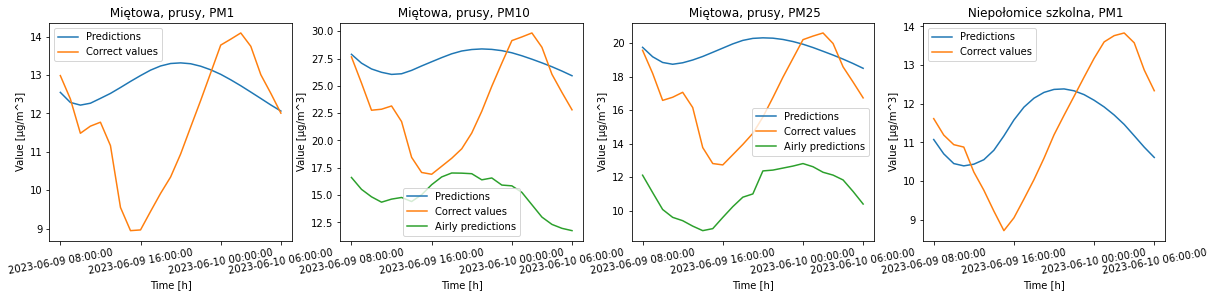

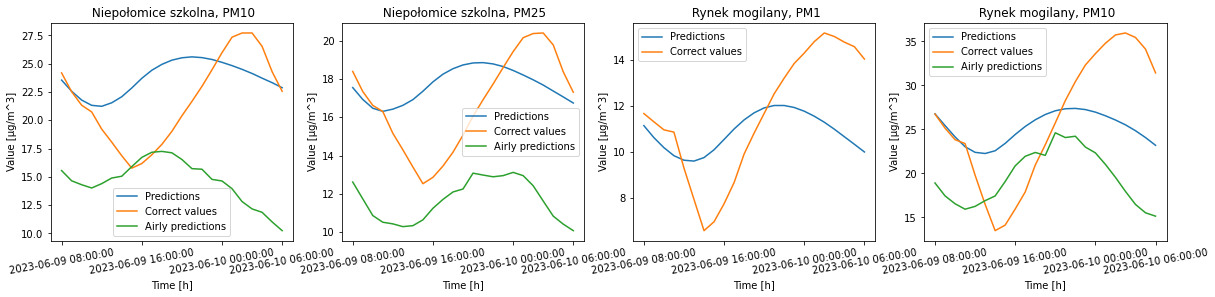

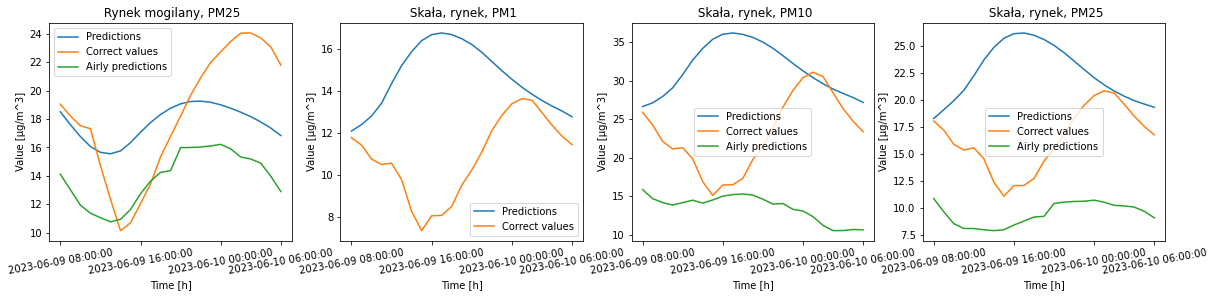

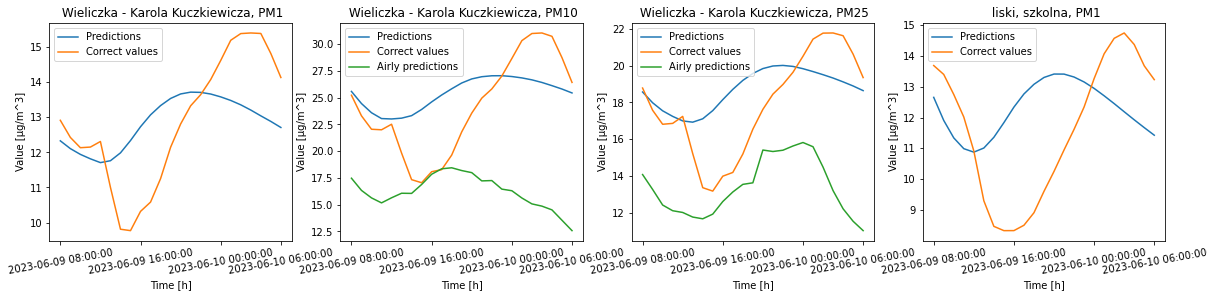

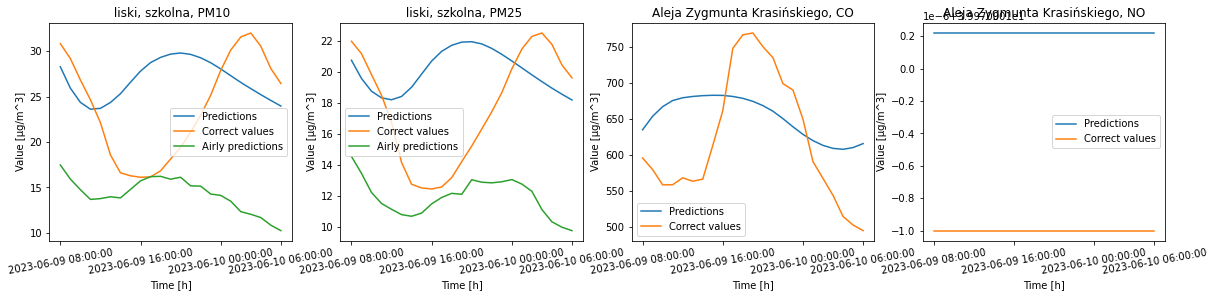

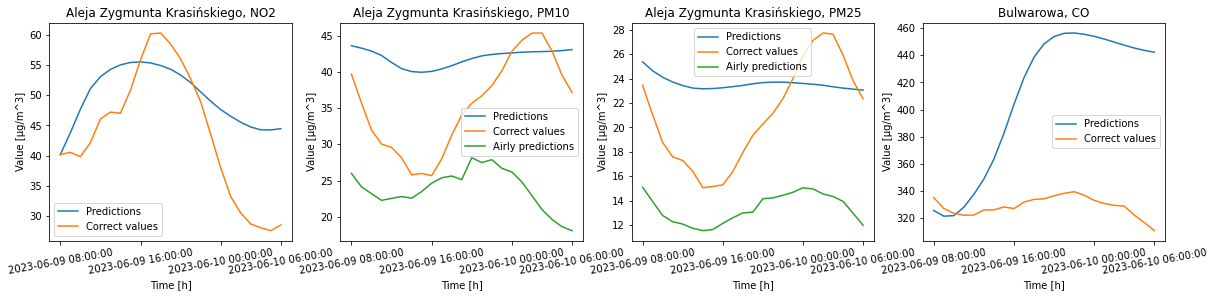

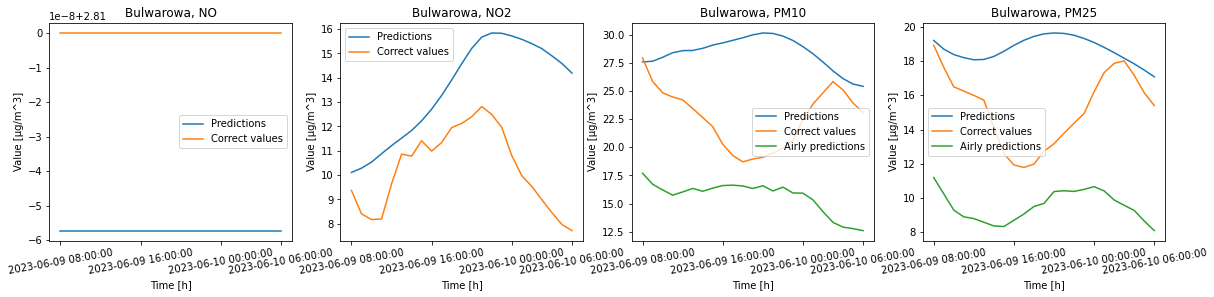

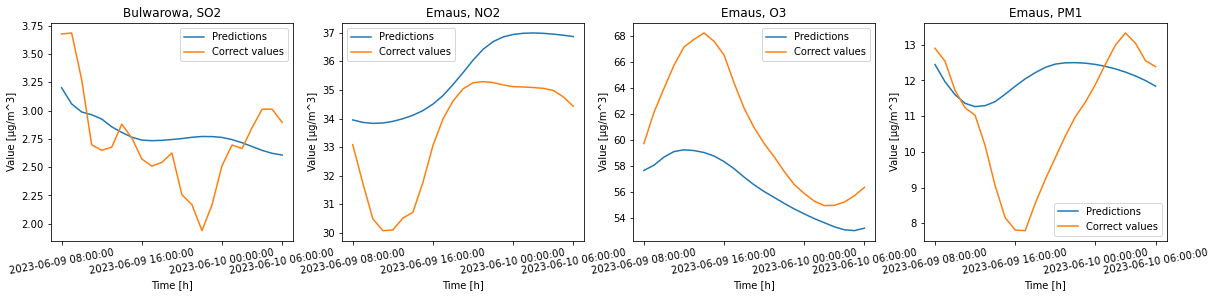

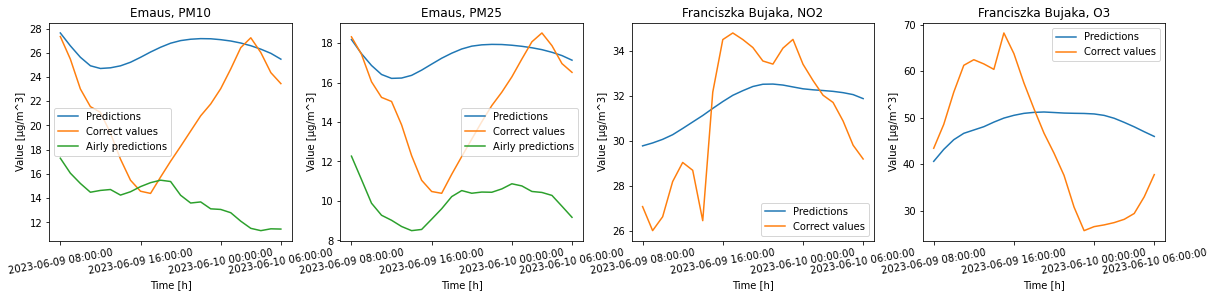

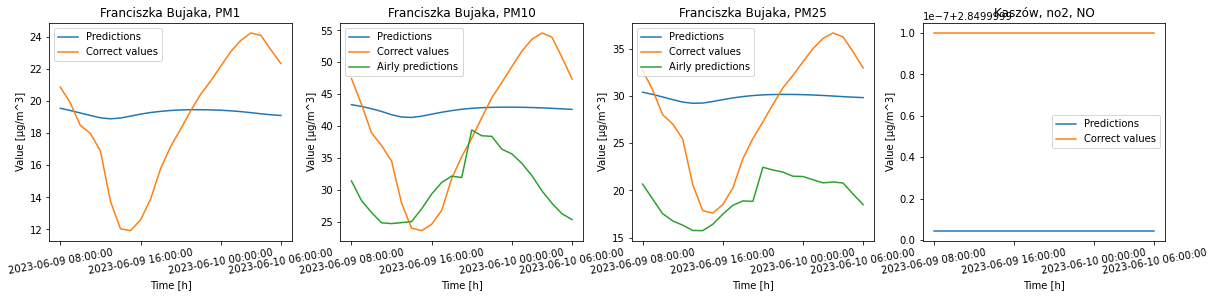

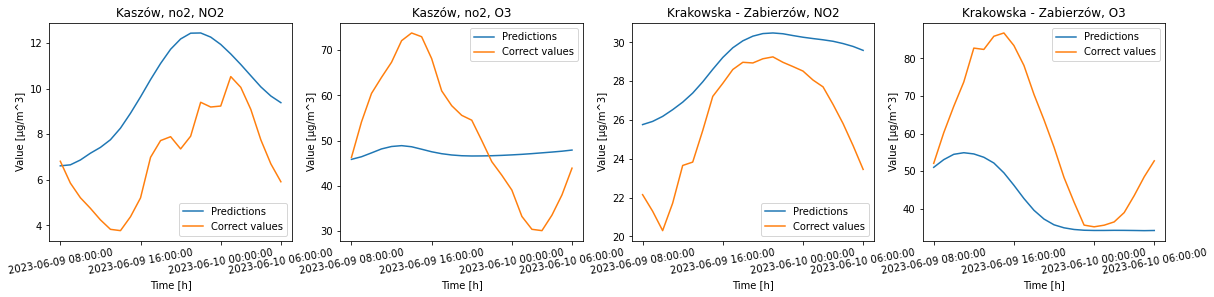

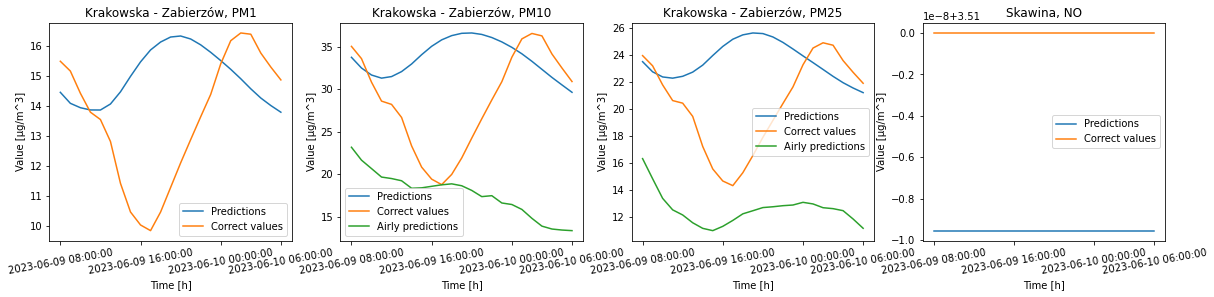

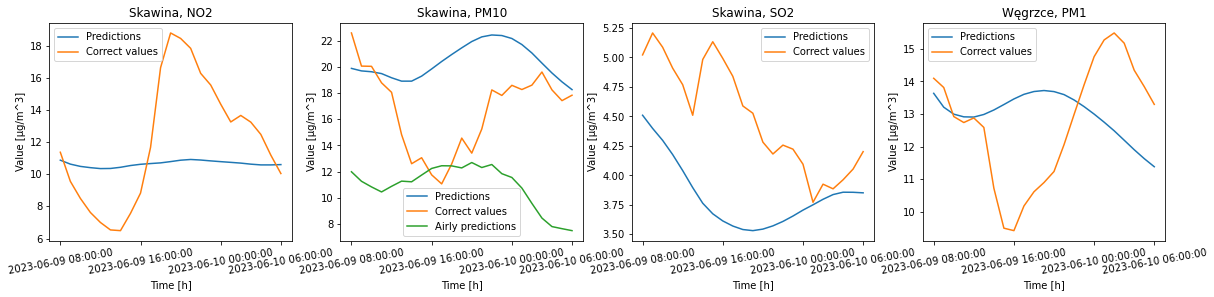

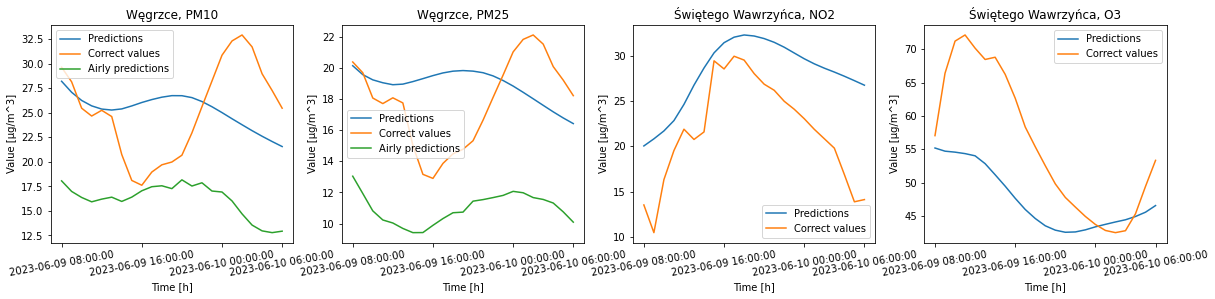

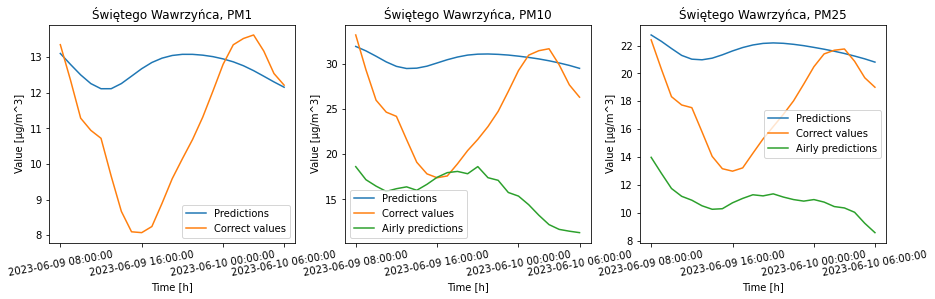

In [82]:
HOURS = [4, 6, 12, 24]
errors_df, errors_airly = calc_errors(HOURS)

In [85]:
def plot_weather():
    fig, ax = None, None
    k = 0
    to_show = df_s[~df_s['Pollution'].isin(WEATHER_VALUES)].count()["Station"]
    for n in range(N):
        if df_s.loc[n]['Pollution'] not in WEATHER_VALUES:
            continue
        if k%4 == 0:
            fig, ax = plt.subplots(1, min(4, to_show-k))
            fig.set_size_inches(min(4, to_show-k)*5, 4)
        times = [str(last_time + pd.Timedelta(i, unit='H')) for i in range(23)]
        ax[k%4].plot(times, real[1:, n], label="Correct values")
        ax[k%4].set_title(f"{df_s.loc[n]['Station']}, {df_s.loc[n]['Pollution']}")
        ax[k%4].set_ylabel(f"Value [{POLLUTION_TO_UNIT[df_s.loc[n]['Pollution']]}]")
        ax[k%4].set_xlabel("Time [h]")
        ax[k%4].tick_params(axis='x', rotation=10)
        ax[k%4].set_xticks([times[0], times[8], times[16], times[-1]])
        if k%4 == 3:
            plt.show()
            fig.clear()
        k += 1

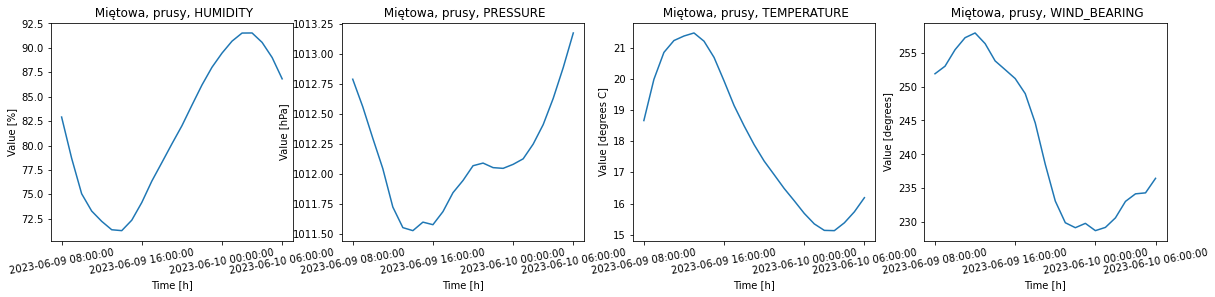

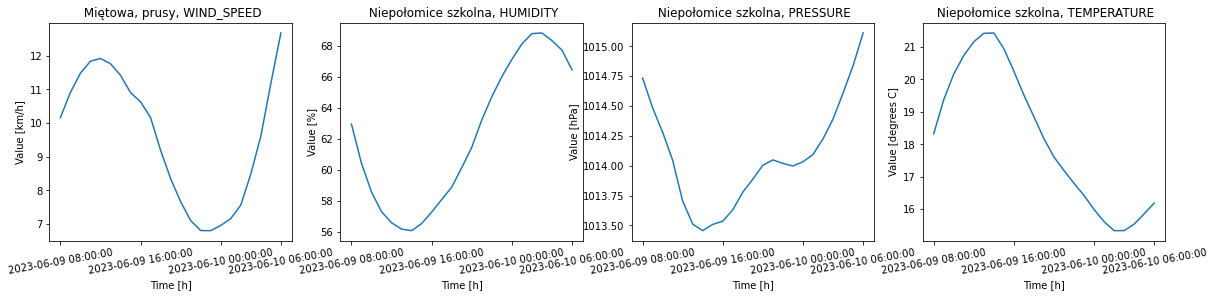

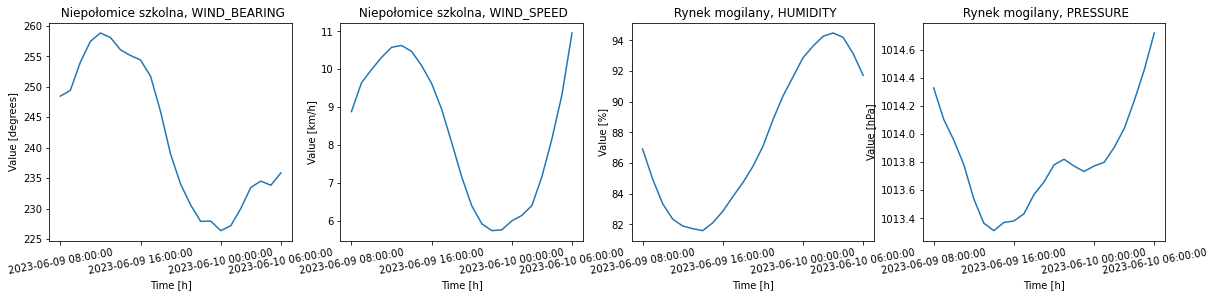

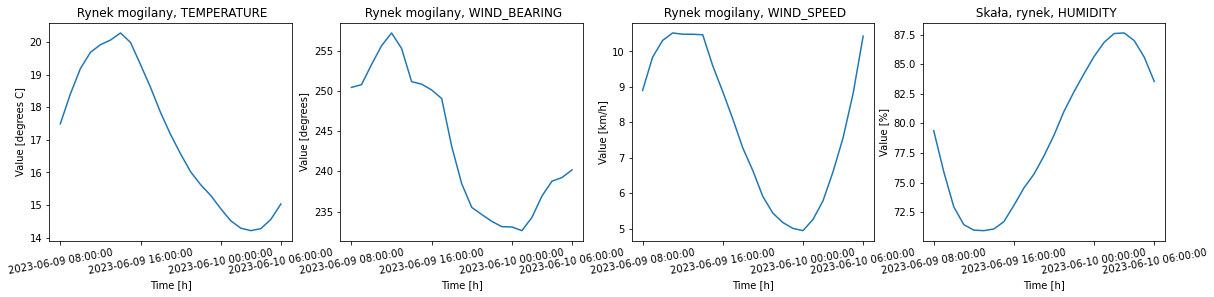

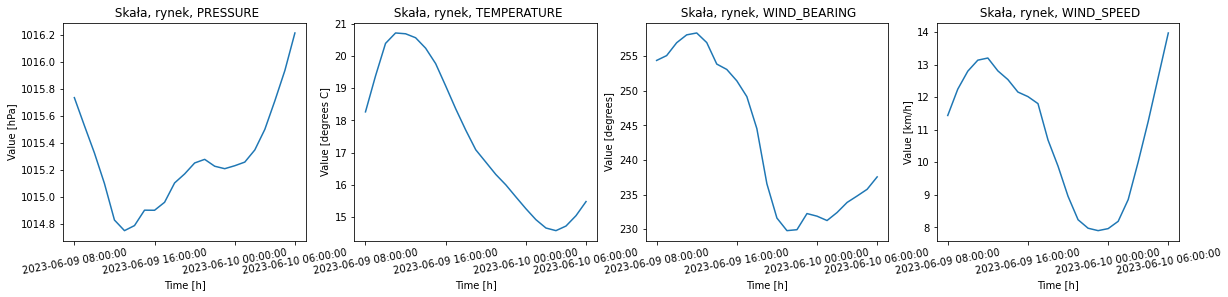

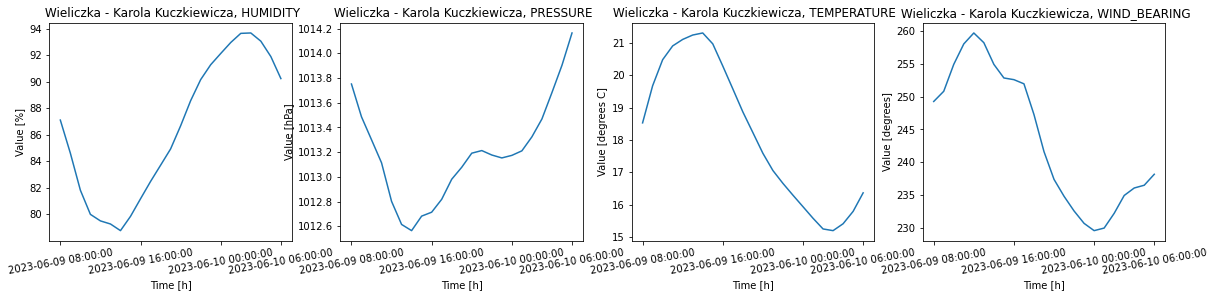

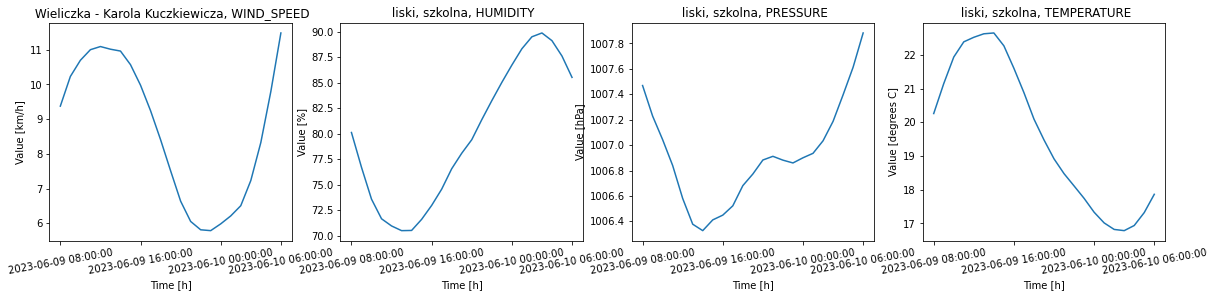

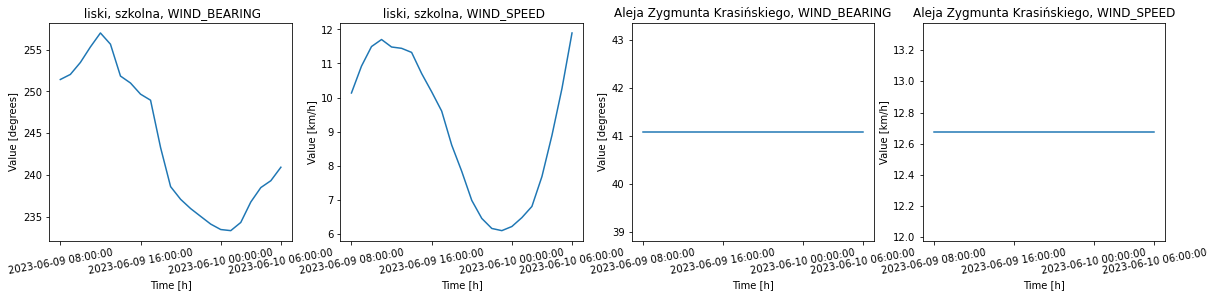

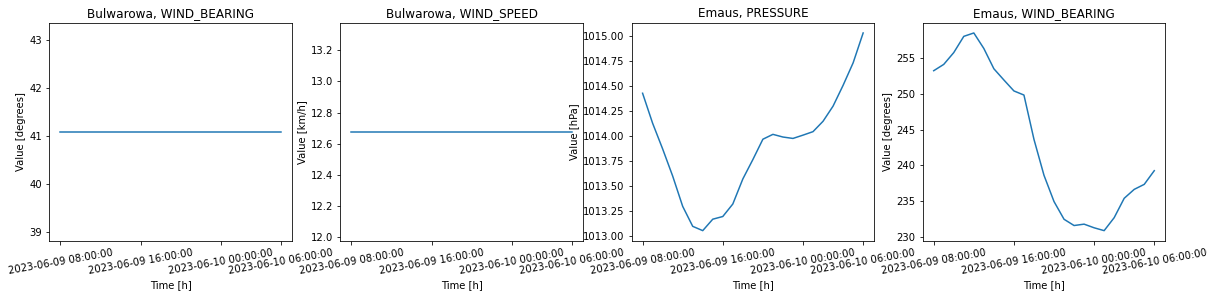

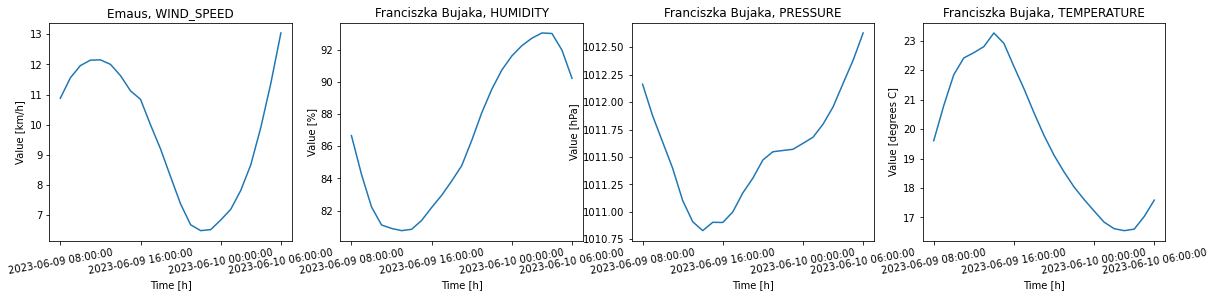

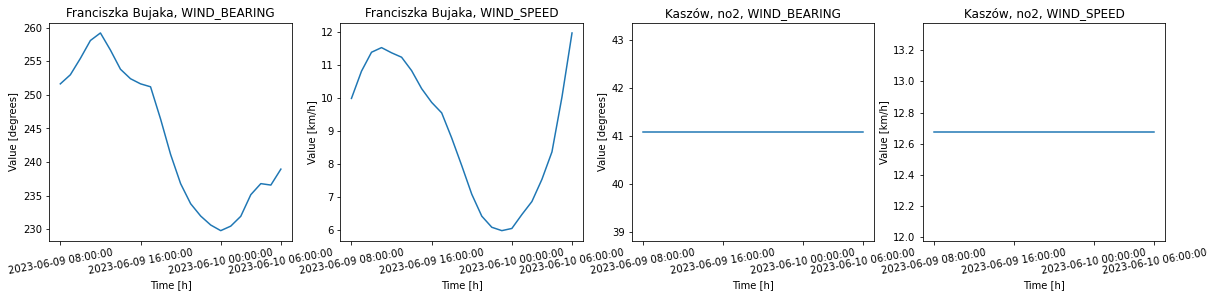

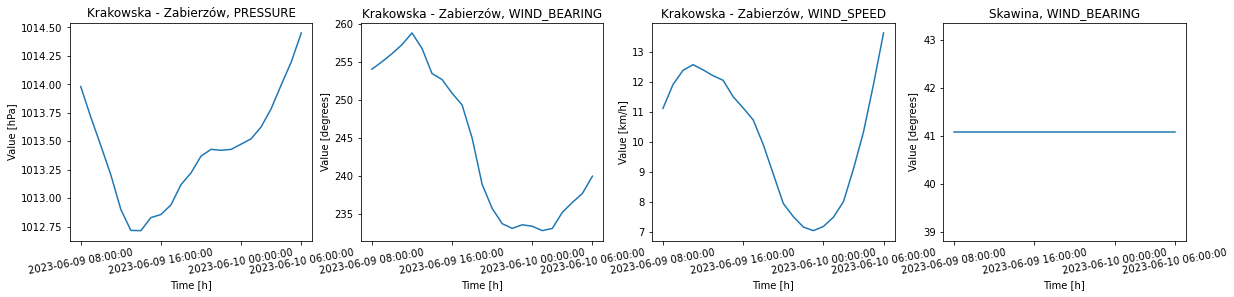

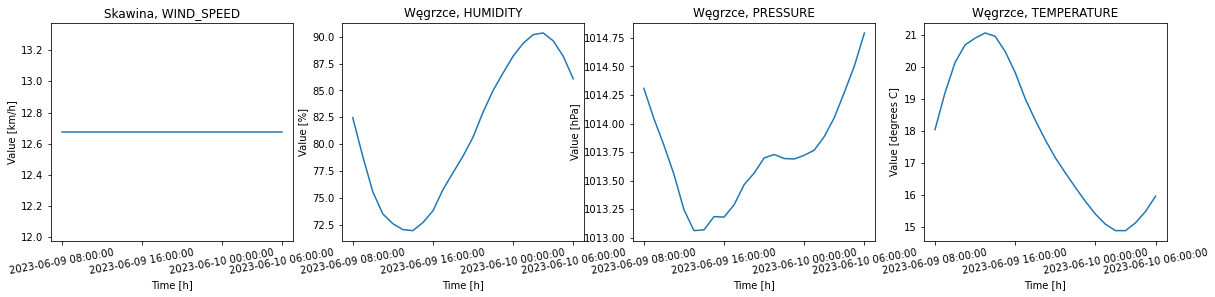

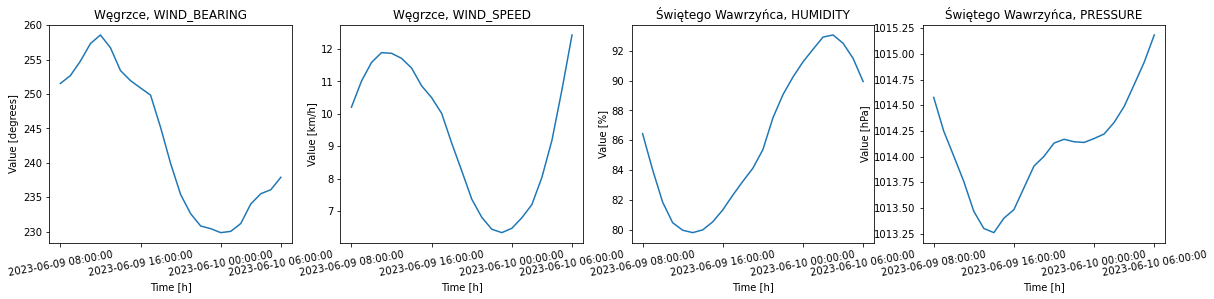

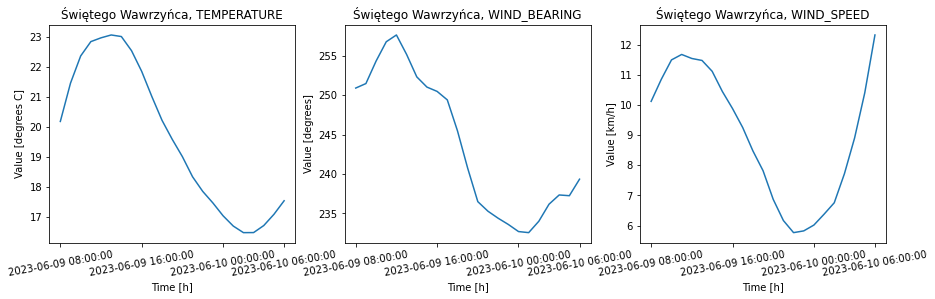

In [86]:
plot_weather()

In [87]:
def left_to_right(x, norm):
    return x/norm*100.

def right_to_left(x, norm):
    return x*norm/100.

In [94]:
from functools import partial

POLLUTION_TO_NORM = {
    "PM1": 5,
    "PM25": 15,
    "PM10": 45,
    "NO2": 25,
    "O3": 100,
    "SO2": 40,
    "CO": 4000,
    "H2S": 100,
    "NO": 30,
}

def plot_errors(errors, hours):
    averages = {}
    n_index = 0
    fig, ax = None, None
    for hour in hours:
        n = 0
        for pollution in errors['Pollution'].unique():
            if pollution in WEATHER_VALUES:
                continue
            if n_index%4 == 0:
                fig, ax = plt.subplots(1, 4)
                fig.set_size_inches(36, 4)

            stations = []
            values = []
            for index, row in errors.loc[(errors["Pollution"] == pollution) & (errors["Hours"] == hour), ["RMSE", "Station"]].iterrows():
                stations.append(row["Station"])
                values.append(row["RMSE"])
            stations.append("Average")
            values.append(np.mean(np.array(values)))
            averages[(pollution, hour)] = np.mean(np.array(values))
            ax[n_index%4].bar(stations, values, width=0.4)
            ax[n_index%4].set_title(f"RMSE for {pollution}, for {hour}h")
            ax[n_index%4].set_ylabel(f"Value [{POLLUTION_TO_UNIT[pollution]}]")
            ax[n_index%4].tick_params(axis='x', rotation=90)

            norm = POLLUTION_TO_NORM[pollution]
            first = partial(left_to_right, norm=norm)
            second = partial(right_to_left, norm=norm)
            secax = ax[n_index%4].secondary_yaxis('right', functions=(first, second))
            secax.set_ylabel("Percentage of norm [%]")
            if n_index%4 == 3:
                plt.show()
                fig.clear()
            n+=1
            n_index += 1
    return averages

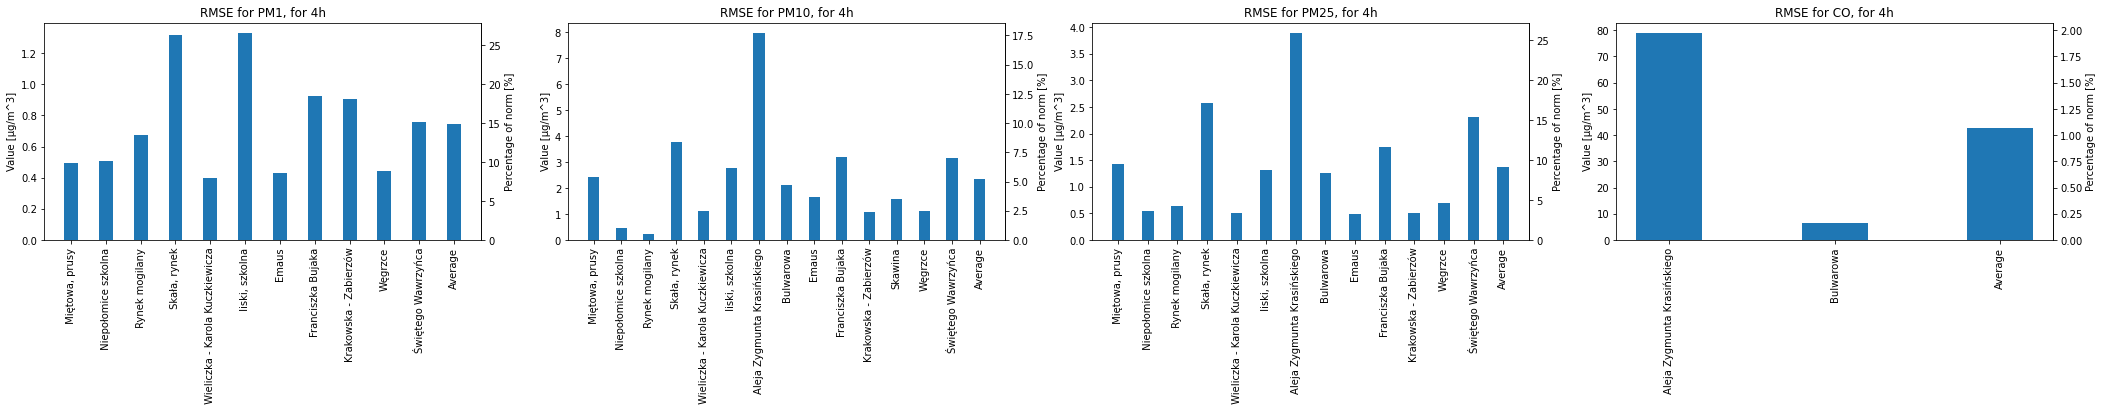

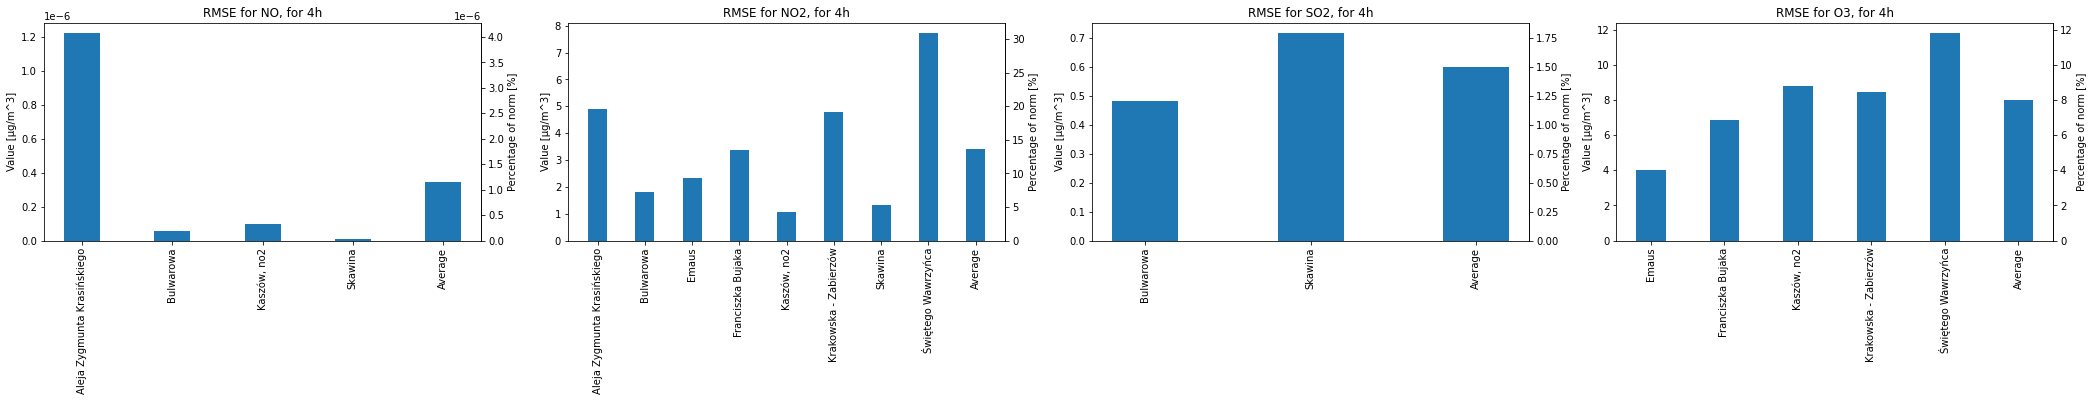

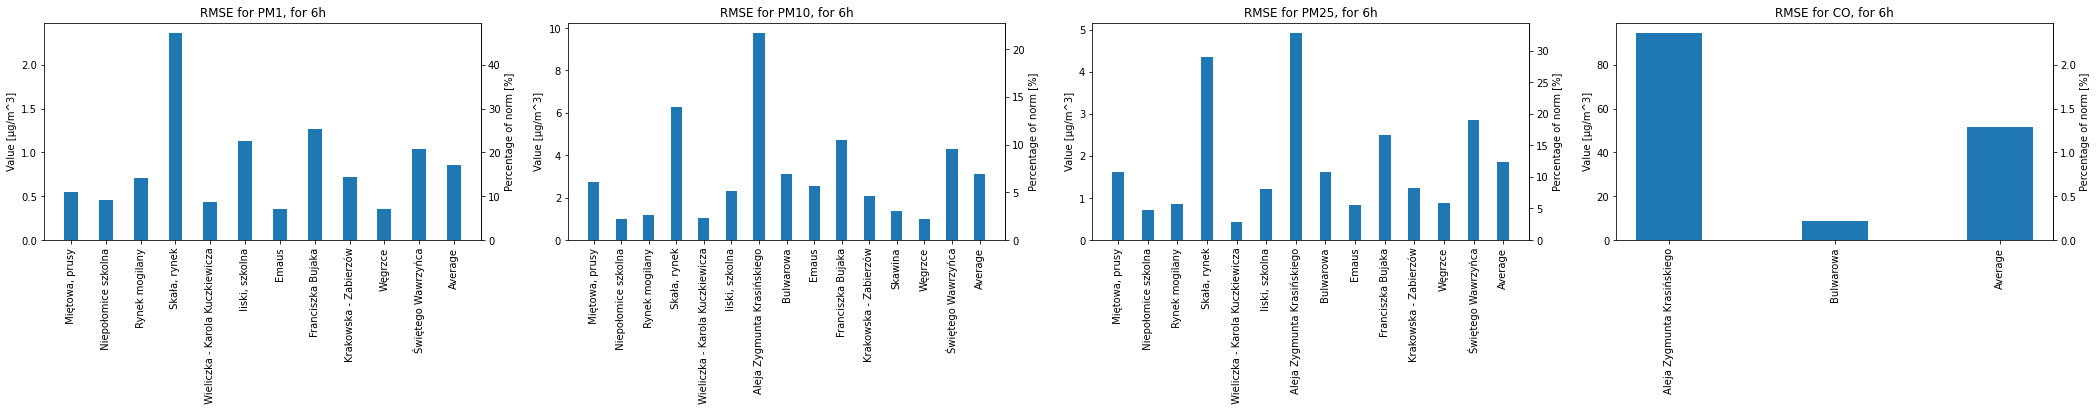

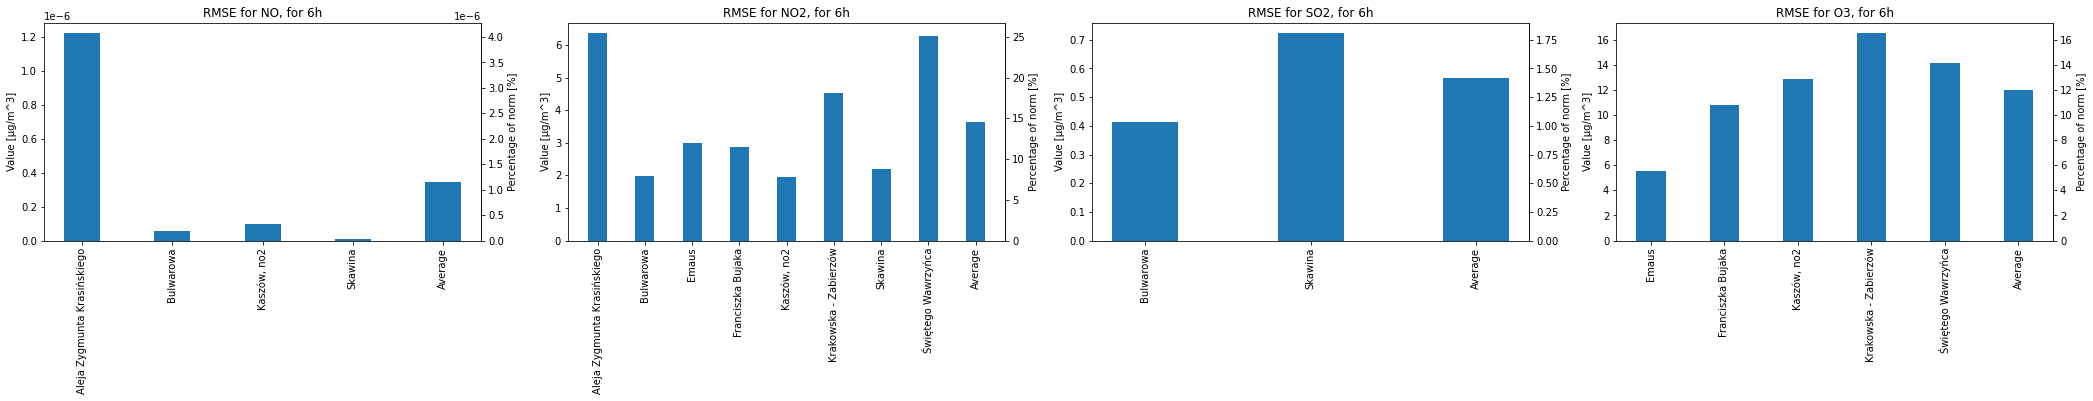

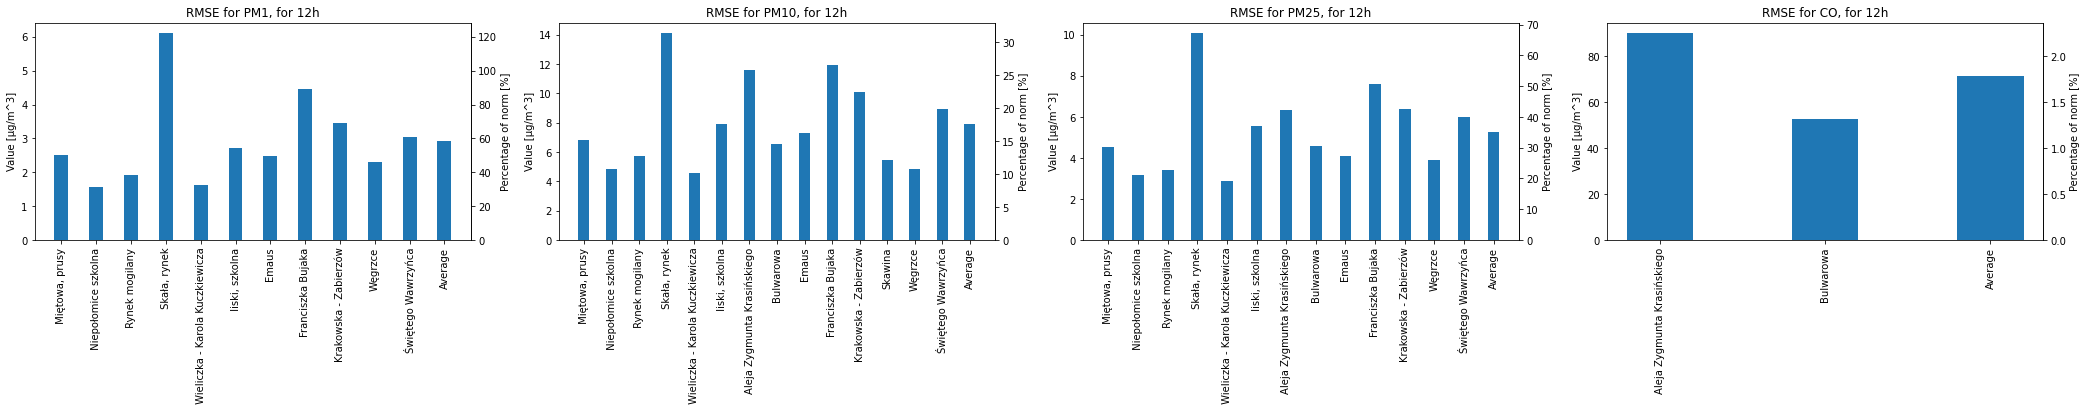

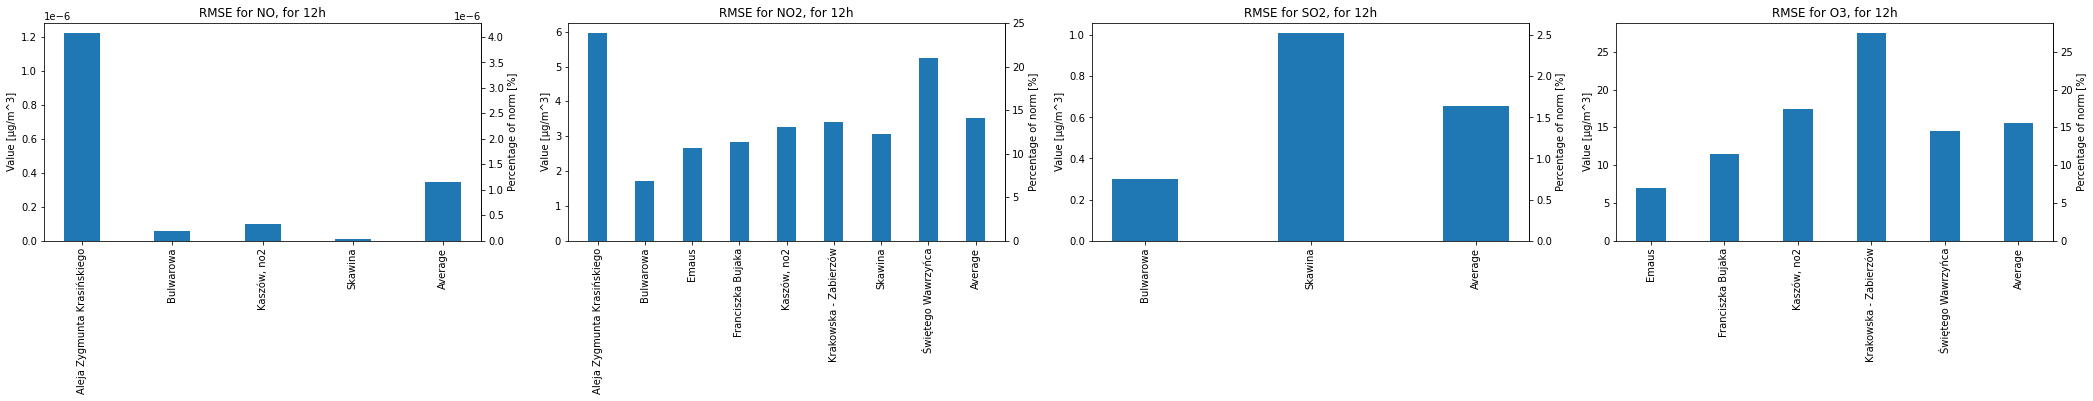

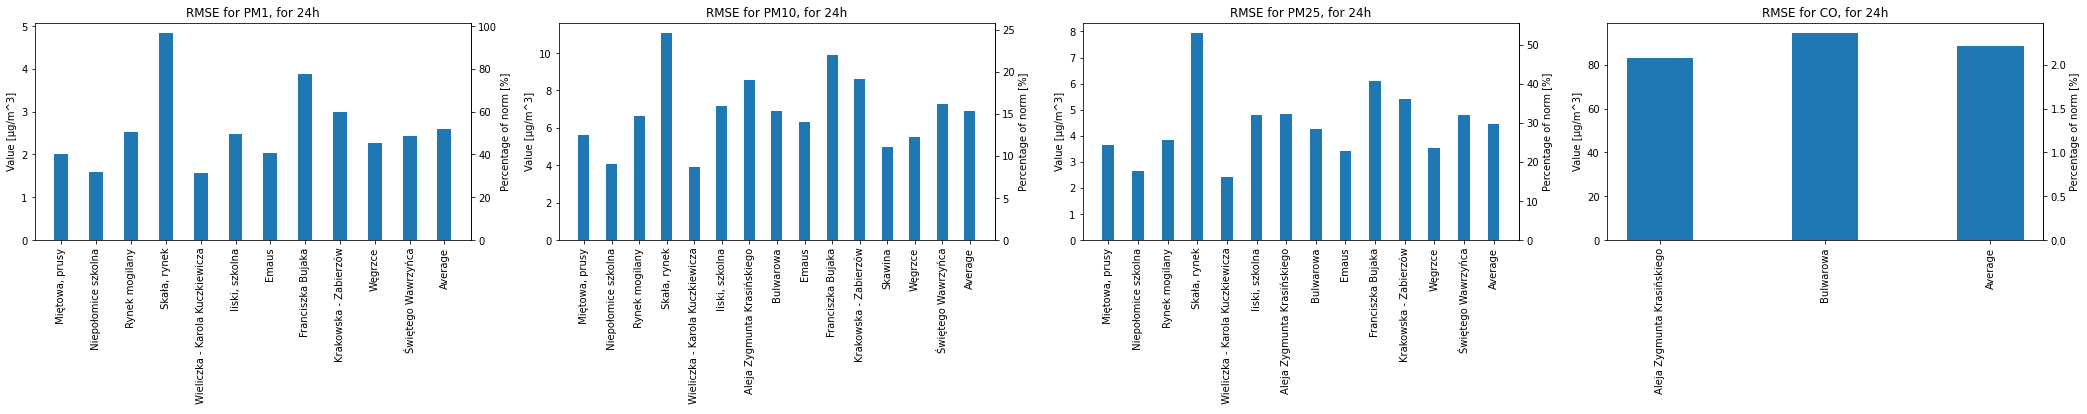

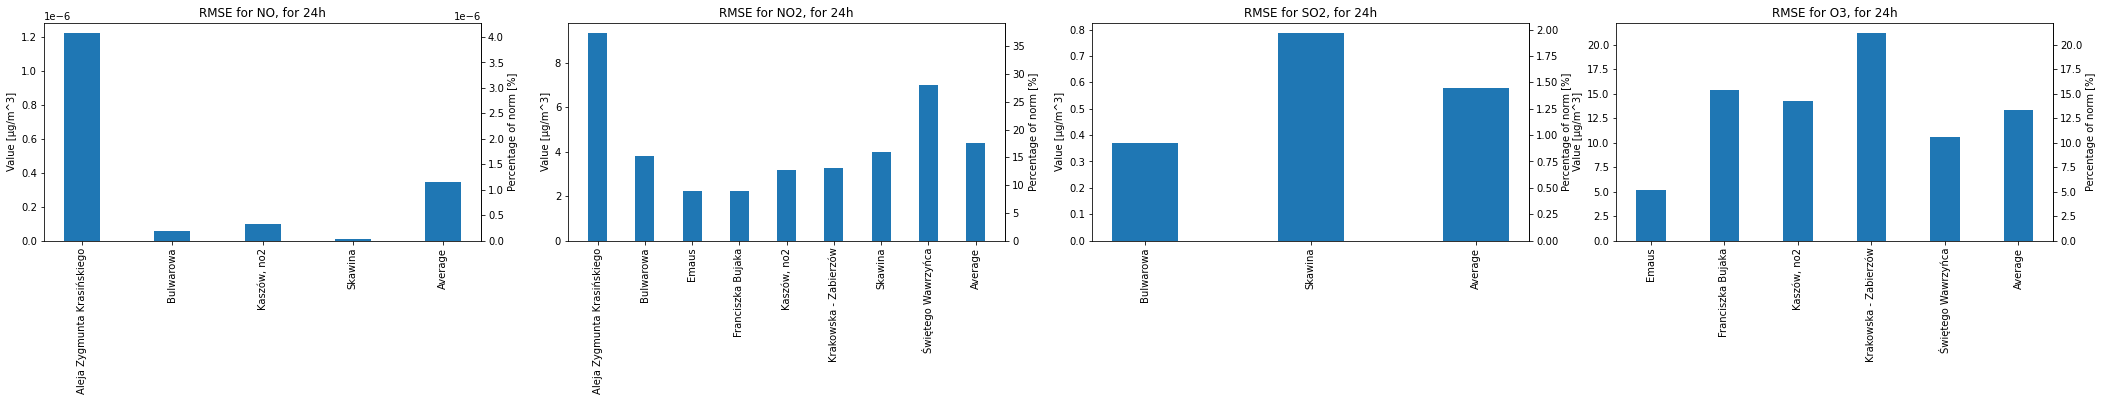

In [95]:
df_averages = plot_errors(errors_df, HOURS)

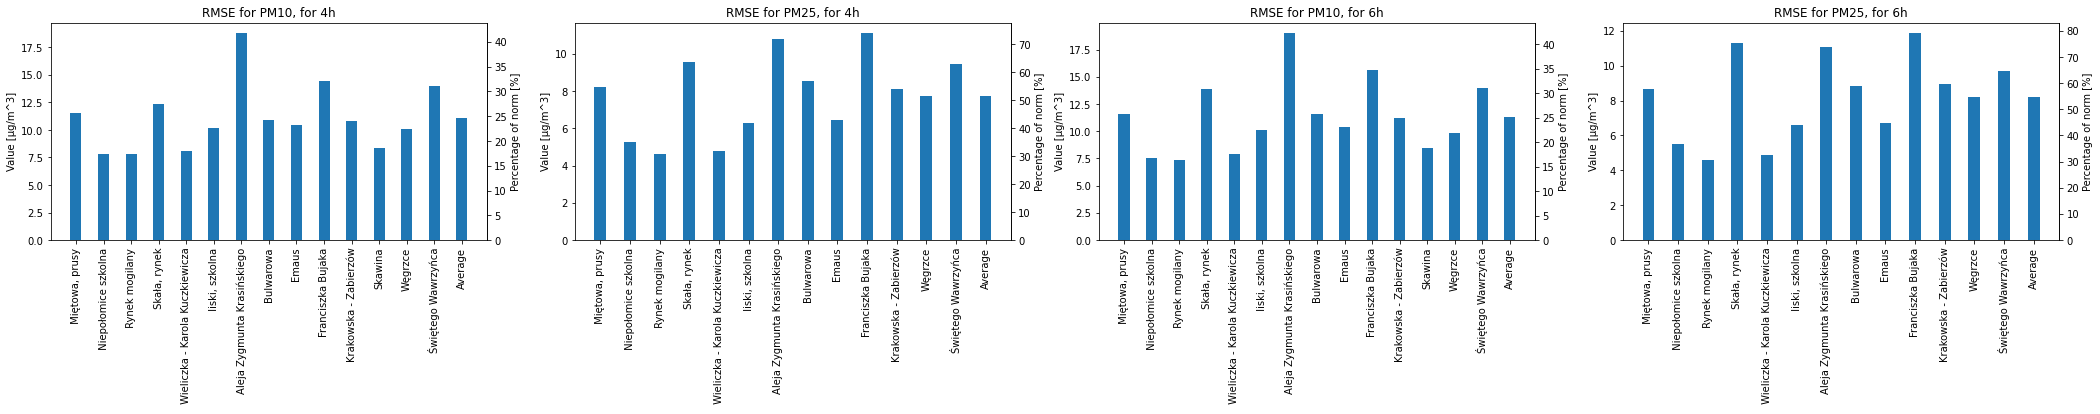

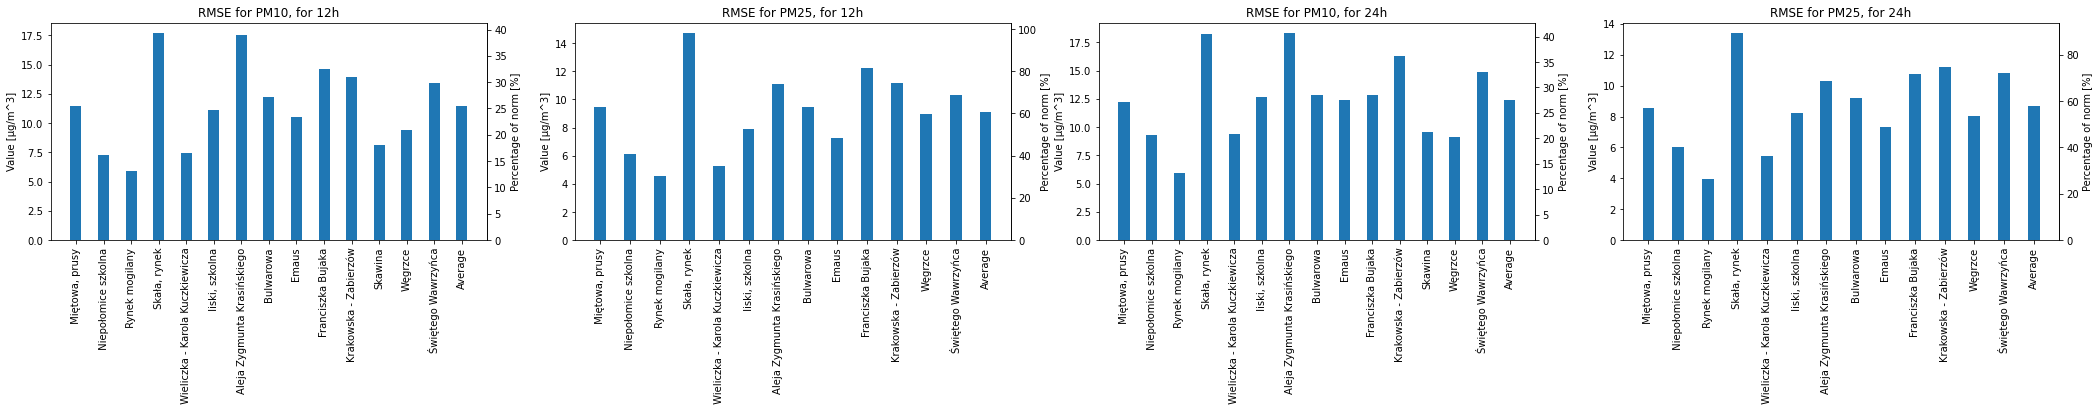

In [96]:
airly_averages = plot_errors(errors_airly, HOURS)

In [92]:
def plot_averages(custom_averages, airly_averages, hours, pollutions):
    fig, ax = None, None
    n = 0
    for pollution in pollutions:
        if n%4 == 0:
            fig, ax = plt.subplots(1, 4)
            fig.set_size_inches(36, 5)
        values = []
        labels = []
        for hour in hours:
            values.append(custom_averages[(pollution, hour)])
            labels.append(f"Custom, {pollution} for {hour}h")
        if "PM10" in pollution or "PM25" in pollution:
            for hour in hours:
                values.append(airly_averages[(pollution, hour)])
                labels.append(f"Airly, {pollution} for {hour}h")

        ax[n%4].bar(labels, values, width=0.4)
        ax[n%4].set_title(f"Average RMSE for {pollution} based on period of prediction.")
        ax[n%4].set_ylabel(f"Value [{POLLUTION_TO_UNIT[pollution]}]")
        ax[n%4].tick_params(axis='x', rotation=90)

        norm = POLLUTION_TO_NORM[pollution]
        first = partial(left_to_right, norm=norm)
        second = partial(right_to_left, norm=norm)
        secax = ax[n%4].secondary_yaxis('right', functions=(first, second))
        secax.set_ylabel("Percentage of norm [%]")

        if n%4 == 3:
            plt.show()
            fig.clear()
        n += 1

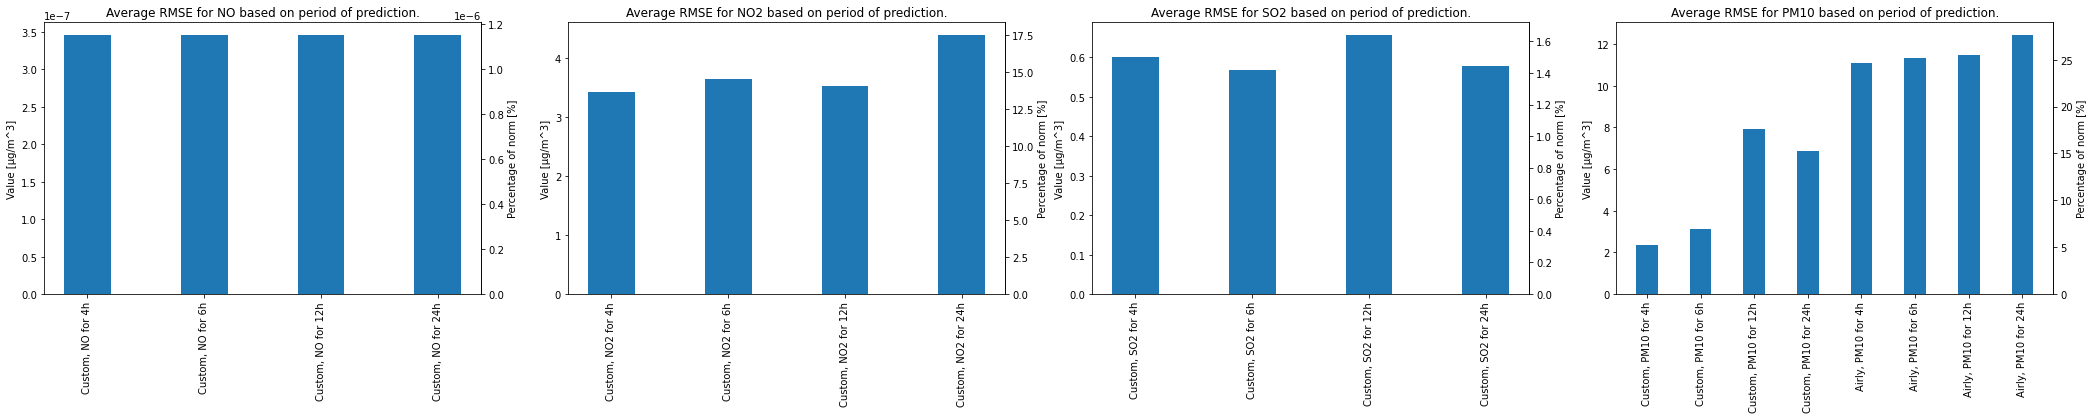

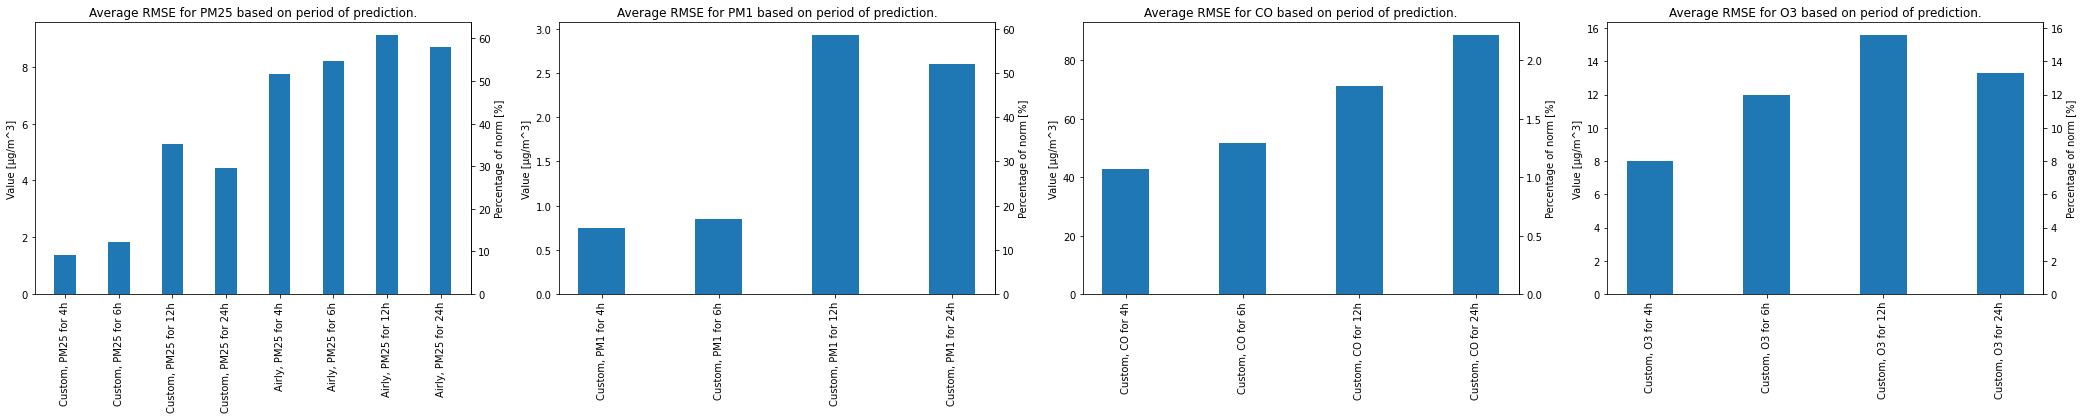

In [93]:
plot_averages(df_averages, airly_averages, HOURS, ["NO", "NO2", "SO2", "PM10", "PM25", "PM1", "CO", "O3"])